Data set from Kaggle: 

https://www.kaggle.com/datasets/mexwell/heart-disease-dataset

In [1]:
!pip install catboost matplotlib pandas scikit-learn kaggle optuna ipywidgets kaleido shap jupyterlab-rise

In [2]:
#!dir ../../../home/vscode

In [3]:
import os
from pathlib import Path
container_check = os.getenv("iscontainer")
if container_check=="y":
    config_dir = Path("/home/vscode/.config/kaggle")
    config_dir.mkdir(parents=True, exist_ok=True)
    
    with open(config_dir / "kaggle.json", "w") as dst:
        with open("./kaggle.json", "r") as src:
            dst.write(src.read())

In [4]:
import os
import zipfile
from pathlib import Path
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

# dataset = "heart-disease-dataset"
# dataset_test = "mexwell/heart-disease-dataset"
# download_folder = Path("data/heart-disease")
# zip_path = download_folder / "heart-disease.zip"
# download_folder.mkdir(parents=True, exist_ok=True)

# api.competition_download_files(dataset, path=str(download_folder))
# api.dataset_download_files(dataset_test, path=str(download_folder), unzip=True)

dataset_name = "mexwell/heart-disease-dataset"
download_folder = Path("data/heart-disease")
download_folder.mkdir(parents=True, exist_ok=True)

api.dataset_download_files(dataset_name, path=str(download_folder), unzip=True)


# with zipfile.ZipFile(zip_path, "r") as zip_ref:
#     zip_ref.extractall(str(download_folder))
# os.remove(zip_path)

Dataset URL: https://www.kaggle.com/datasets/mexwell/heart-disease-dataset


In [5]:
!dir "./data/heart-disease"

 Volume in drive C has no label.
 Volume Serial Number is D0EF-588E

 Directory of c:\Users\Wojciech\Documents\WWSI\ARISA-MLOps-Assignment\data\heart-disease

27.04.2025  22:41    <DIR>          .
27.04.2025  22:41    <DIR>          ..
27.04.2025  22:41           420�674 documentation.pdf
27.04.2025  22:41            39�689 heart_statlog_cleveland_hungary_final.csv
               2 File(s)        460�363 bytes
               2 Dir(s)  103�510�130�688 bytes free


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv(download_folder / "heart_statlog_cleveland_hungary_final.csv")
# df_ids = df_train.pop("PassengerId")
#df.sample(10)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 238 entries, 390 to 599
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  238 non-null    int64  
 1   sex                  238 non-null    int64  
 2   chest pain type      238 non-null    int64  
 3   resting bp s         238 non-null    int64  
 4   cholesterol          238 non-null    int64  
 5   fasting blood sugar  238 non-null    int64  
 6   resting ecg          238 non-null    int64  
 7   max heart rate       238 non-null    int64  
 8   exercise angina      238 non-null    int64  
 9   oldpeak              238 non-null    float64
 10  ST slope             238 non-null    int64  
 11  target               238 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 24.2 KB


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 952 entries, 1005 to 1126
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  952 non-null    int64  
 1   sex                  952 non-null    int64  
 2   chest pain type      952 non-null    int64  
 3   resting bp s         952 non-null    int64  
 4   cholesterol          952 non-null    int64  
 5   fasting blood sugar  952 non-null    int64  
 6   resting ecg          952 non-null    int64  
 7   max heart rate       952 non-null    int64  
 8   exercise angina      952 non-null    int64  
 9   oldpeak              952 non-null    float64
 10  ST slope             952 non-null    int64  
 11  target               952 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 96.7 KB


In [9]:
y_train = df_train.pop("target")
X_train = df_train


In [10]:
y_test = df_test.pop("target")
X_test = df_test

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 952 entries, 1005 to 1126
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  952 non-null    int64  
 1   sex                  952 non-null    int64  
 2   chest pain type      952 non-null    int64  
 3   resting bp s         952 non-null    int64  
 4   cholesterol          952 non-null    int64  
 5   fasting blood sugar  952 non-null    int64  
 6   resting ecg          952 non-null    int64  
 7   max heart rate       952 non-null    int64  
 8   exercise angina      952 non-null    int64  
 9   oldpeak              952 non-null    float64
 10  ST slope             952 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 89.2 KB


In [12]:
import joblib
import optuna
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv

outfolder = Path("results")
outfolder.mkdir(parents=True, exist_ok=True)

best_params_path = outfolder / "best_params.pkl"

if not best_params_path.is_file():
    X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    
    def objective(trial):
        params = {
            "depth": trial.suggest_int("depth", 2, 10),
            "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3),
            "iterations": trial.suggest_int("iterations", 100, 300),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 100.0, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.01, 1),
            "random_strength": trial.suggest_float("random_strength", 1e-5, 100.0, log=True)
        }
        model = CatBoostClassifier(**params, verbose=0)
        model.fit(X_train_opt, y_train_opt, eval_set=(X_val_opt, y_val_opt), early_stopping_rounds=50)
        return model.get_best_score()["validation"]["Logloss"]
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)
    
    joblib.dump(study.best_params, best_params_path)
    params = study.best_params
else:
    params = joblib.load(best_params_path)
print("Best Parameters:", params)

Best Parameters: {'depth': 9, 'learning_rate': 0.1989710549297809, 'iterations': 225, 'l2_leaf_reg': 5.203681083589466, 'bagging_temperature': 0.6748870052060675, 'random_strength': 0.27921747675539976}


In [13]:
params["eval_metric"] = "F1"
params["loss_function"] = "Logloss"

model = CatBoostClassifier(
    **params,
    verbose=True
)

data = Pool(X_train, y_train)

cv_results = cv(
    params=params,
    pool=data,
    fold_count=5,
    partition_random_seed=42,
    shuffle=True,
)

cv_results.to_csv(outfolder / "cv_results.csv", index=False)

Training on fold [0/5]
0:	learn: 0.9111969	test: 0.7977528	best: 0.7977528 (0)	total: 162ms	remaining: 36.3s
1:	learn: 0.9408805	test: 0.8494624	best: 0.8494624 (1)	total: 166ms	remaining: 18.5s
2:	learn: 0.9375000	test: 0.8615385	best: 0.8615385 (2)	total: 169ms	remaining: 12.5s
3:	learn: 0.9486859	test: 0.8691099	best: 0.8691099 (3)	total: 172ms	remaining: 9.52s
4:	learn: 0.9589041	test: 0.8677249	best: 0.8691099 (3)	total: 175ms	remaining: 7.71s
5:	learn: 0.9612984	test: 0.8854167	best: 0.8854167 (5)	total: 179ms	remaining: 6.52s
6:	learn: 0.9652605	test: 0.8808290	best: 0.8854167 (5)	total: 182ms	remaining: 5.67s
7:	learn: 0.9714994	test: 0.8979592	best: 0.8979592 (7)	total: 185ms	remaining: 5.02s
8:	learn: 0.9725686	test: 0.8865979	best: 0.8979592 (7)	total: 188ms	remaining: 4.51s
9:	learn: 0.9775561	test: 0.8958333	best: 0.8979592 (7)	total: 191ms	remaining: 4.11s
10:	learn: 0.9812734	test: 0.8958333	best: 0.8979592 (7)	total: 195ms	remaining: 3.79s
11:	learn: 0.9812734	test: 0.9

In [14]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add mean performance line
fig.add_trace(
    go.Scatter(
        x=cv_results["iterations"], y=cv_results["test-F1-mean"], mode="lines", name="Mean F1 Score", line=dict(color="blue")
    )
)

# Add shaded error region
fig.add_trace(
    go.Scatter(
        x=pd.concat([cv_results["iterations"], cv_results["iterations"][::-1]]),
        y=pd.concat([cv_results["test-F1-mean"]+cv_results["test-F1-std"], 
                     cv_results["test-F1-mean"]-cv_results["test-F1-std"]]),
        fill="toself", 
        fillcolor="rgba(0, 0, 255, 0.2)",
        line=dict(color="rgba(255, 255, 255, 0)"),
        showlegend=False
    )
)

# Customize layout
fig.update_layout(
    title="Cross-Validation (N=5) Mean F1 score with Error Bands",
    xaxis_title="Training Steps",
    yaxis_title="Performance Score",
    template="plotly_white",
    yaxis=dict(range=[0.5, 1])
)

fig.show()

fig.write_image(outfolder / "test_f1.png")

In [15]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add mean performance line
fig.add_trace(
    go.Scatter(
        x=cv_results["iterations"], y=cv_results["test-Logloss-mean"], mode="lines", name="Mean logloss", line=dict(color="blue")
    )
)

# Add shaded error region
fig.add_trace(
    go.Scatter(
        x=pd.concat([cv_results["iterations"], cv_results["iterations"][::-1]]),
        y=pd.concat([cv_results["test-Logloss-mean"]+cv_results["test-Logloss-std"], 
                     cv_results["test-Logloss-mean"]-cv_results["test-Logloss-std"]]),
        fill="toself", 
        fillcolor="rgba(0, 0, 255, 0.2)",
        line=dict(color="rgba(255, 255, 255, 0)"),
        showlegend=False
    )
)

# Customize layout
fig.update_layout(
    title="Cross-Validation (N=5) Mean Logloss with Error Bands",
    xaxis_title="Training Steps",
    yaxis_title="Logloss",
    template="plotly_white"
)

fig.show()

fig.write_image(outfolder / "test_logloss.png")

In [16]:
model.fit(
    X_train,
    y_train,
    verbose_eval=50,
    early_stopping_rounds=50,
    use_best_model=False,
    plot=True
)

model.save_model(outfolder / 'catboost_model_heart_disease.cbm')
joblib.dump(params, outfolder / 'model_params.pkl')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9014085	total: 4.1ms	remaining: 918ms
50:	learn: 0.9989970	total: 199ms	remaining: 680ms
100:	learn: 1.0000000	total: 395ms	remaining: 485ms
150:	learn: 1.0000000	total: 584ms	remaining: 286ms
200:	learn: 1.0000000	total: 782ms	remaining: 93.3ms
224:	learn: 1.0000000	total: 873ms	remaining: 0us


['results\\model_params.pkl']

In [17]:
#df_test = pd.read_csv(download_folder / "test.csv")

In [18]:
model.predict(df_test)

array([1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1])

In [19]:
preds = model.predict(df_test[X_train.columns])

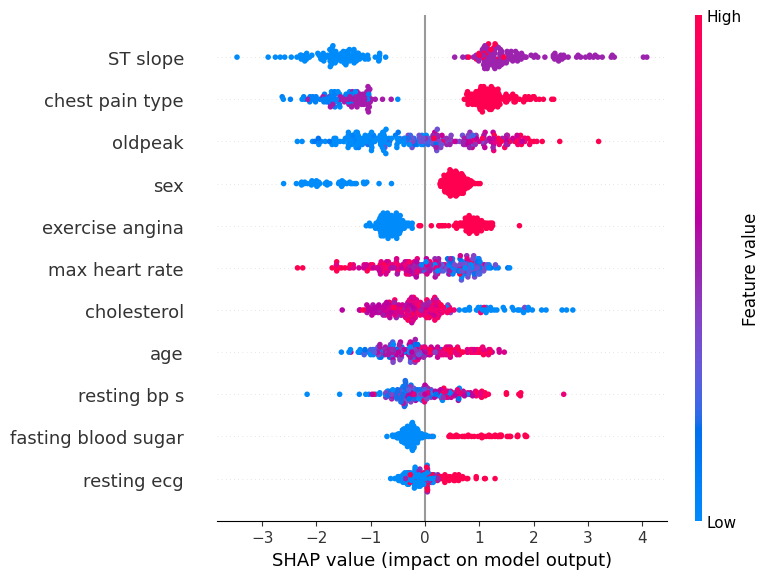

In [20]:
import shap
import matplotlib.pyplot as plt
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_test)

shap.summary_plot(shap_values, df_test, show=False)
plt.savefig(outfolder / "test_shap_overall.png")

In [21]:
df_test["target"] = preds
df_test.to_csv(outfolder / "predictions.csv", index=False)